# Importazione librerie e visualizzazione Dataset

In [2]:
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

In [3]:
#Lettura del dataset:
df_trump = pd.read_csv("/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv",lineterminator='\n')
df_biden = pd.read_csv("/kaggle/input/us-election-2020-tweets/hashtag_joebiden.csv",lineterminator='\n')

In [4]:
print(f"Tweet with Trump hashtag: {len(df_trump)}")
print(f"Tweet with Biden hashtag: {len(df_biden)}")

Tweet with Trump hashtag: 970919
Tweet with Biden hashtag: 776886


In [5]:
#Dataframe unito (eliminati i duplicati)
df_duplicated = pd.concat([df_trump,df_biden])
df = df_duplicated.drop_duplicates(subset="tweet")

print(f"Total tweets: {len(df_duplicated)}")
print(f"Total tweets: {len(df)}")

Total tweets: 1747805
Total tweets: 1507205


In [6]:
df.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [7]:
df.tail()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
776880,2020-11-08 23:59:37,1.325589e+18,Hypocrite!\n\n#Biden \n#Covid_19 https://t.co/...,2.0,0.0,Twitter Web App,9.583685e+17,van Lith de Jeude,LithJeude,"Stop this crazy and altruistic theory of ""We m...",...,541.0,Venus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.743523
776882,2020-11-08 23:59:38,1.325589e+18,Ωχ ελπίζω να μη μας βγει σαν τους οπαδούς του...,0.0,0.0,Twitter for Android,4.032819e+08,οχι άλλο κάρβουνο 🇬🇷🗣🗣🗣,anapodoi,ακραία καιρικά φαινόμενα... ζήσαμε και απόψε,...,772.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.947617
776883,2020-11-08 23:59:41,1.325589e+18,L'OTAN va sortir de sa léthargie et redevenir ...,48.0,14.0,Twitter for Android,7.819183e+17,🇫🇷 Alt-Droite (matricule 6921) ✝️ 🇬🇷 🇮🇹 🇦🇲,CtrlAltDroite,Fils de mineur. Libertés - Identité - Solidari...,...,15806.0,France,46.603354,1.888334,NaN,France,Europe,NaN,NaN,2020-11-09 18:32:45.627335
776884,2020-11-08 23:59:52,1.325589e+18,🌎\n\n“#congiuntifuoriregione”\n\n‘Sono felice ...,1.0,1.0,Twitter for iPhone,5.293315e+08,Angelo Tani,AngeloTani,nato a casa dei nonni,...,5974.0,🌎,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.599846
776885,2020-11-08 23:59:58,1.325589e+18,"Ik moet zeggen dat ik #Biden ""the lesser of tw...",0.0,0.0,Twitter for Android,5.863863e+08,Job,_JobO__,-voeg hier uw interessante bio toe-,...,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.747707


In [8]:
#Numero di utenti totali (potenziali nodi)
print(df["user_id"].value_counts())

user_id
7.426862e+07    1352
4.017365e+07    1324
1.244982e+18    1259
3.863951e+08    1223
8.742585e+08    1059
                ... 
1.318602e+18       1
1.207354e+18       1
4.701694e+08       1
1.028358e+18       1
1.295867e+18       1
Name: count, Length: 481068, dtype: int64


In [9]:
from collections import Counter
import re

def extract_hashtags(tweet):
    return re.findall(r'#\w+', tweet.lower())

df['hashtags'] = df['tweet'].apply(extract_hashtags)

all_hashtags = [hashtag for hashtags in df['hashtags'] for hashtag in hashtags]

hashtag_counts = Counter(all_hashtags)

sorted_hashtag_counts = hashtag_counts.most_common()

# Stampare la classifica degli hashtag
print("Classifica degli hashtag più usati:")
for hashtag, count in sorted_hashtag_counts[:50]:
    print(f"{hashtag}: {count}")

/tmp/ipykernel_34/2497207750.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hashtags'] = df['tweet'].apply(extract_hashtags)


Classifica degli hashtag più usati:
#trump: 863347
#biden: 500781
#joebiden: 295275
#election2020: 139924
#donaldtrump: 132085
#elections2020: 77590
#bidenharris2020: 69976
#trump2020: 66393
#vote: 58299
#electionday: 48413
#usa: 45016
#maga: 42982
#covid19: 38383
#kamalaharris: 37605
#biden2020: 29940
#electionnight: 27977
#uselection2020: 27542
#bidenharris: 26712
#america: 25089
#elecciones2020: 22864
#electionresults2020: 22861
#trumpmeltdown: 20640
#usaelections2020: 19958
#bidenharis2020: 19367
#debates2020: 19012
#democrats: 18316
#vote2020: 17682
#gop: 17331
#election: 16943
#coronavirus: 16796
#trumpvsbiden: 16670
#election2020results: 16606
#elections: 16043
#usaelection2020: 15554
#maga2020: 14578
#covid: 14239
#pennsylvania: 14156
#hunterbiden: 14129
#uselections2020: 14014
#2020election: 13844
#uselection: 13477
#cnn: 13441
#trumpislosing: 12883
#obama: 12785
#potus: 12186
#byebyetrump: 12113
#joebiden2020: 12076
#joebidenkamalaharris2020: 12041
#votehimout: 11950
#foxnews

Osservazioni:
- Informazioni temporali che vanno dal 15 ottobre 2020 al 8 novembre 2020.
- 481.000 potenziali nodi (filtraggio sulla base di like/retweet?)
- Tweet scritti in diverse lingue (concentrarsi solo su quelli in inglese?)
- Diversi valori mancanti nelle aree geografiche

# Preprocessing (filtraggio tweet/utenti)

Probabilmente il primo filtraggio che occorre fare è quello sulla lingua. Potrebbe essere meglio considerare solo i tweet in inglese (?)

In [10]:
#Filtraggio sulla base dei like
df_like_5 = df[df["likes"]>=5]
df_like_10 = df[df["likes"]>=10]
df_like_20 = df[df["likes"]>=20]
df_like_50 = df[df["likes"]>=50]

print(f"Total tweets: {len(df_like_5)}")
print(f"Total tweets: {len(df_like_10)}")
print(f"Total tweets: {len(df_like_20)}")
print(f"Total tweets: {len(df_like_50)}")
print(df_like_50["user_id"].value_counts())

Total tweets: 175404
Total tweets: 100234
Total tweets: 58783
Total tweets: 28596
user_id
1.232811e+08    338
7.042227e+17    245
3.968686e+08    241
2.783875e+09    234
3.924067e+07    199
               ... 
1.189810e+18      1
1.357710e+09      1
9.185330e+07      1
1.311773e+18      1
9.416288e+17      1
Name: count, Length: 10235, dtype: int64


In [11]:
#Filtraggio sulla base dei retweet
df_retweet_5 = df[df["retweet_count"]>=5]
df_retweet_10 = df[df["retweet_count"]>=10]
df_retweet_20 = df[df["retweet_count"]>=20]
df_retweet_50 = df[df["retweet_count"]>=50]

print(f"Total tweets: {len(df_retweet_5)}")
print(f"Total tweets: {len(df_retweet_10)}")
print(f"Total tweets: {len(df_retweet_20)}")
print(f"Total tweets: {len(df_retweet_50)}")
print(df_retweet_50["user_id"].value_counts())

Total tweets: 59557
Total tweets: 32206
Total tweets: 17720
Total tweets: 7765
user_id
1.214316e+18    149
2.909782e+07    134
1.232811e+08    105
1.824706e+07     99
4.990740e+08     78
               ... 
4.706692e+07      1
2.621748e+08      1
2.298251e+08      1
7.820675e+08      1
1.988165e+08      1
Name: count, Length: 2848, dtype: int64


In [12]:
#FILTRAGGIO BASATO SU stato= United states
df_country= df[df["country"]=="United States of America"]
print(f"Total tweets: {len(df_country)}")

print(df_country["user_id"].value_counts())
df_country.tail()

Total tweets: 297754
user_id
1.244982e+18    1259
8.742585e+08    1059
4.132841e+06     980
2.086079e+08     856
1.154952e+18     785
                ... 
2.171204e+08       1
1.406658e+07       1
1.446436e+08       1
3.845704e+07       1
1.071796e+18       1
Name: count, Length: 76160, dtype: int64


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtags
776827,2020-11-08 23:54:14,1.325587e+18,George W. #Bush #Congratulates #Biden And Harr...,1.0,1.0,Twitter for iPhone,4.938816e+07,Carol Falk,CAFalk,https://t.co/uuyj7Dnata Activist: #Resistance ...,...,Wisconsin,44.430898,-89.688464,NaN,United States of America,North America,Wisconsin,WI,2020-11-09 18:32:45.705803,"[#bush, #congratulates, #biden]"
776845,2020-11-08 23:56:15,1.325588e+18,Will #criticalRaceTheory become ubiquitous in ...,0.0,0.0,Twitter Web App,4.095715e+08,Howard Wachtel,mindovermath,Retired college #math professor. Single. Brid...,...,"Philadelphia, PA",39.952724,-75.163526,Philadelphia,United States of America,North America,Pennsylvania,PA,2020-11-09 18:32:45.773127,"[#criticalracetheory, #biden]"
776847,2020-11-08 23:56:21,1.325588e+18,You moving near #Biden 🤔 https://t.co/1F6i1YIJ2P,0.0,0.0,Twitter for iPhone,1.914600e+08,Sean Lassiter,IAmSeanLassiter,Sean Lassiter Photography,...,Philadelphia PA,39.952724,-75.163526,Philadelphia,United States of America,North America,Pennsylvania,PA,2020-11-09 18:32:45.731141,[#biden]
776865,2020-11-08 23:58:24,1.325589e+18,@FLOTUS I’m excited to have a FLOTUS whose vag...,0.0,0.0,Twitter for iPhone,5.545625e+07,Caroline Billinson,cbillinson,my love language is dismantling the patriarchy.,...,"Washington, DC",38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-11-09 18:32:45.841439,[#biden]
776870,2020-11-08 23:58:48,1.325589e+18,The man needs some help...#usa #biden\nWhen wi...,0.0,0.0,Twitter for Android,1.248047e+18,Dr J,DrJoeMcCarthy,Human. Free Thinker. Met Mandela. Personal. Fa...,...,Earth. 3rd Planet from Sun.,43.519630,-114.315320,NaN,United States of America,North America,Idaho,ID,2020-11-09 18:32:45.641087,"[#usa, #biden]"


# Costruisco la rete con le menzioni

* Obiettivo: costruire una rete che tenga conto delle menzioni che provengono da utenti USA con più di 15.000 followers (potenzialmente i più influenti).
* Obiettivo: costruire una rete che tenga conto delle menzioni che provengono da utenti USA con meno di 1.000 followers, studiamo comportamento tipico di persone meno famose.
* Misurazione delle principali misure di centralità: in_degree, betweness, closeness.
* Si potrebbe verificare con l'out_degree se sono presenti spam_farm (to do)
* Degree distribution (to do)
* Page rank (to do)

In [ ]:
popular = False #se true, considero rete con >15.000 followers, se false considero rete con <1.000 followers

#FILTRAGGIO BASATO SU stato= United states e sul numero di follower, voglio capire se ci sono
#utenti importanti o se ho completamente rimosso profili di informazione
if popular:
    df_country_e_follower= df_country[df_country["user_followers_count"]>=15000]
else:
    df_country_e_follower= df_country[df_country["user_followers_count"]<1000]
print(f"Total tweets: {len(df_country_e_follower)}")
print(df_country_e_follower["user_id"].value_counts())
df_country_e_follower.tail()


In [ ]:
#FILTRAGGIO BASATO SU MENZIONI+country+followers
def contains_mentions(tweet):
    return '@' in tweet

df_with_mentions = df_country_e_follower[df_country_e_follower['tweet'].apply(contains_mentions)]

print(f"Total tweets: {len(df_with_mentions)}")

df_with_mentions.head()
print(df_with_mentions["user_id"].value_counts())
#PS MI SONO ACCORTA CHE NON è BANALE REALIZZARE UN ARCO SE C'è UNA MENZIONE
#DEVI RISALIRE AL USER ID DAL NOME 
#MA QUELL'UTENTE POTREBBE NON ESISTERE NEI DATI SE NON HA PUBBLICATO NIENTE (ci interessa davvero se abbia pubblicato qualcosa?)

In [ ]:
import re
# Initialize a directed graph
G = nx.DiGraph()

# Function to extract mentioned users from a tweet
def extract_mentions(tweet):
    return re.findall(r"@(\w+)", tweet)

# Add nodes and edges based on mentions
for index, row in df_with_mentions.iterrows():
    user_screen_name = row['user_screen_name'] #nome dell'utente
    mentions = extract_mentions(row['tweet']) #menzioni dell'utente verso altri utenti
    
    # Add the user as a node
    if not G.has_node(user_screen_name): #se utente non presente, lo aggiungo alla rete
        G.add_node(user_screen_name)
    
    # Add edges from the user to each mentioned user if the mentioned user is already a node
    for mention in mentions:
        if not G.has_node(mention): #se il nodo menzionato non è presente, lo aggiungo alla rete
            G.add_node(mention)
        if mention!=user_screen_name: #rimuovo i selfloop (automenzioni)
            G.add_edge(user_screen_name, mention)
        

# Display the number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

La rete è troppo grande, è il caso di applicare ulteriori filtraggi? (Per esempio, considerare utenti che hanno almeno un certo numero di menzioni), controllo con un parametro "min_number_of_mentions", elimino tutti i nodi che hanno un in_degree inferiore a una certa soglia.

In [ ]:
min_number_of_mentions = 1

in_degrees = dict(G.in_degree())
nodes_to_remove = [node for node, degree in in_degrees.items() if degree < min_number_of_mentions]

# Rimuovere i nodi dal grafo
G.remove_nodes_from(nodes_to_remove)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Non va bene questo approccio, elimino troppi archi all'interno della rete perdendo informazione.

In [ ]:
import matplotlib.pyplot as plt

# Plot the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)
nx.draw(G, pos, with_labels=True, node_size=20, node_color='blue', font_size=10, font_color='white')
plt.title(' Network utenti menzioni provenienti da tweet di utenti USA con >15000 follower')
plt.show()

Per ora la rete è orientata, quindi c'è un arco da n1 a n2 se n1 menziona n2.

In [ ]:
# Betweenness Centrality
"""
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['user_screen_name', 'betweenness_centrality'])
betweenness_df = betweenness_df.sort_values(by='betweenness_centrality', ascending=False)
print(betweenness_df.head())
"""

betweenness_centrality = nx.betweenness_centrality(G)

# Ordiniamo i nodi in base ai valori di betweenness centrality in ordine decrescente
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di betweenness centrality
for node, centrality in sorted_betweenness[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Betweenness Centrality: {centrality:.6f}')

Betweness centrality molto bassa

In [ ]:
# Degree Centrality
"""
degree_centrality = nx.degree_centrality(G)
degree_df = pd.DataFrame(list(degree_centrality.items()), columns=['user_screen_name', 'degree_centrality'])
degree_df = degree_df.sort_values(by='degree_centrality', ascending=False)
print(degree_df.head())
"""

degree_centrality = nx.in_degree_centrality(G)

# Ordiniamo i nodi in base ai valori di degree centrality in ordine decrescente
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di degree centrality
for node, centrality in sorted_degree[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Degree Centrality: {centrality:.6f}')

In [ ]:
#Closeness 
"""
closeness_centrality = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['user_screen_name', 'closeness_centrality'])
closeness_df = closeness_df.sort_values(by='closeness_centrality', ascending=False)
print(closeness_df.head())
"""

closeness_centrality = nx.closeness_centrality(G)

# Ordiniamo i nodi in base ai valori di degree centrality in ordine decrescente
sorted_degree = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di degree centrality
for node, centrality in sorted_degree[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Closeness Centrality: {centrality:.6f}')

Rimuovendo i nodi isolati, la rete diventa più densa e le misure di centralità potrebbero aumentare per alcuni nodi. Questo accade perché la centralità è spesso una misura relativa e viene calcolata rispetto all'intera rete. Eliminare i nodi che non hanno connessioni (e quindi non contribuiscono alla rete) può far sì che i nodi rimanenti abbiano un impatto maggiore.

In [ ]:
# Rimuovere i nodi isolati
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# Display the number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

#Vengono rimossi pochi nodi (una ventina, probabilmente sono nodi che si automenzionano e basta)

In [ ]:
"""
# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['user_screen_name', 'betweenness_centrality'])
betweenness_df = betweenness_df.sort_values(by='betweenness_centrality', ascending=False)
print(betweenness_df.head())
#Closeness 
closeness_centrality = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['user_screen_name', 'closeness_centrality'])
closeness_df = closeness_df.sort_values(by='closeness_centrality', ascending=False)
print(closeness_df.head())
# Degree Centrality
degree_centrality = nx.degree_centrality(G)
degree_df = pd.DataFrame(list(degree_centrality.items()), columns=['user_screen_name', 'degree_centrality'])
degree_df = degree_df.sort_values(by='degree_centrality', ascending=False)
print(degree_df.head())
"""

In [ ]:
import matplotlib.pyplot as plt

# Plot the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)

#Nodi piu grandi sono associati a degree centrality maggiore
node_size = [v * 10000 for v in degree_centrality.values()]


nx.draw(G, pos, with_labels=True, node_size=node_size, node_color='blue', font_size=10, font_color='black', edge_color='gray')
plt.title(' Network utenti USA con >15000 follower')
plt.show()

# Costruisco la rete geografica
* è una rete non orientata
* Considero solo gli utenti negli USA e che hanno stato!=null
* Inserisco un arco tra gli utenti dello stesso stato
* Classifico ogni utente in pro-trump / pro-biden e lo coloro di rosso / blu
* Creazione dei sottografi: Utilizziamo G.subgraph(nodes) per creare sottografi per ciascuno stato, selezionando i nodi che appartengono a quel particolare stato.
* **Analisi degli stati con più sostenitori di Trump:** Conta il numero di nodi con preferenza politica "Trump" per ogni stato e stampa i risultati ordinati per numero decrescente.
* **Fornire una predizione dell'esito delle elezioni e confrontarlo con ground trouth**




In [ ]:
pip install transformers

In [ ]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1

# Caricare il modello di sentiment analysis
classifier = pipeline("text-classification", model="DT12the/distilbert-sentiment-analysis", device=device)

In [ ]:
# Definire una funzione per classificare i tweet
#questa è approssimativa, perche se c'è un tweet con due tag?
#inoltre devo considerare una lista di tag con tutte le varianti di tag 
def classify_tweet(tweet):
    result = classifier(tweet)[0]
    if 'Trump' in tweet:
        return 'pro-Trump' if result['label'] == 'LABEL_0' else 'anti-Trump'
    elif 'Biden' in tweet:
        return 'pro-Biden' if result['label'] == 'LABEL_0' else 'anti-Biden'
    else:
        return 'neutral' 

**Costruzione rete**

In [ ]:
print(df.iloc[5]['tweet'])

classify_tweet(df.iloc[5]['tweet'])

In [ ]:
df_country_e_follower= df_country[df_country["user_followers_count"]<1000] #prendo gli utenti meno "popolari"
print(f"Total tweets: {len(df_country_e_follower)}")
print(df_country_e_follower["user_id"].value_counts())

#Concatenazione dei tweet per l'utente
grouped_df = df_country_e_follower.groupby('user_id')['tweet'].apply(lambda tweets: ' '.join(tweets)).reset_index()
print(f"Total tweets after concate: {len(grouped_df)}")

#Drop colonna tweet dal primo dataframe
df_dropped = df_country_e_follower.drop(columns=['tweet'])

#Faccio la join per avere tutti i tweet insieme
df_conc = pd.merge(df_dropped, grouped_df, on='user_id', how='inner')
print(df_conc["user_id"].value_counts())
df_conc.head()

In [ ]:
G_geo = nx.Graph() #NN orient

# Aggiungi nodi (utenti degli USA)
for index, row in df_conc.iterrows(): 
    if  pd.notnull(row['state']):
        political_preference=classify_tweet(row['tweet'])
        #print(political_preference)
        G_geo.add_node(row['user_screen_name'], state=row['state'],
                   political_preference=political_preference)

In [ ]:
#aggiunta archi
for u in G_geo.nodes():
    for v in G_geo.nodes():
        if u != v and G_geo.nodes[u]['state'] == G_geo.nodes[v]['state']:
            G_geo.add_edge(u, v, relationship='same_state')

In [ ]:
# Display the number of nodes and edges
print(f"Number of nodes: {G_geo.number_of_nodes()}")
print(f"Number of edges: {G_geo.number_of_edges()}")

In [ ]:
# Colorazione dei nodi in base alla political_preference
node_colors = []
for node in G_geo.nodes():
    if G_geo.nodes[node]['political_preference'] == 'pro-Biden' or G_geo.nodes[node]['political_preference'] == 'anti-Trump':
        node_colors.append('blue')  # Colore blu per i sostenitori di Biden
    elif G_geo.nodes[node]['political_preference'] == 'pro-Trump'or G_geo.nodes[node]['political_preference'] == 'anti-Biden':
        node_colors.append('red')   # Colore rosso per i sostenitori di Trump
    else:
        node_colors.append('gray')  # Colore grigio per i neutrali
        
# Disegna il grafo con i nodi colorati
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_geo, k=0.1)
nx.draw(G_geo, pos, with_labels=True, node_color=node_colors, node_size=20, font_size=0, font_color='black', edge_color='gray')


In [ ]:
"""
import matplotlib.cm as cm
import numpy as np

# Creazione dei sottografi per ciascuno stato
state_graphs = {}
for state in set(nx.get_node_attributes(G_geo, 'state').values()):
    state_graphs[state] = G_geo.subgraph([n for n, d in G_geo.nodes(data=True) if d['state'] == state])

# Disegna la rete con i cluster stati
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_geo, k=0.1)

# Genera una lista di colori
colors = cm.rainbow(np.linspace(0, 1, len(state_graphs)))

# Disegna i sottografi per ciascuno stato
for color, (state, subgraph) in zip(colors, state_graphs.items()):
    nx.draw_networkx_nodes(subgraph, pos, node_size=20, label=state, node_color=[color] * subgraph.number_of_nodes())
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3)
    

plt.title('Rete sociale con cluster per stati')
plt.legend(state_graphs.keys())
plt.show()
"""

# Costruisco la rete di similarità con gli hashtag

Si pone il seguente problema: potrebbe non essere la scelta giusta andare a escludere utenti per numero di followers. Da un lato potremmo escludere il comportamento tipico degli utenti meno popolari, che sono anche quelli più numerosi (le persone comuni, che poi di fatto vanno a votare), dall'altro potremmo escludere il ruolo di utenti più popolari in grado di influenzare maggiormente gli altri utenti. Potremmo pensare di effettuare un campionamento casuale dei nodi per ridurre la dimensione della rete? Oppure dovremmo pensare al filtraggio sotto altri metodi (numero di like o retweet?). Potremmo fare anche un campionamento che si basa sulla degree distribution. Credo che dovremmo fare campionamento casuale direttamente sul dataset!

In [14]:
print(df_country["user_id"].value_counts())


"""
df_country_e_follower= df_country[df_country["user_followers_count"]>10000] 
print(f"Total tweets: {len(df_country_e_follower)}")
print(df_country_e_follower["user_id"].value_counts())
"""

#Concatenazione dei tweet per l'utente
#df_country_e_follower / df_country
grouped_df = df_country.groupby('user_id')['tweet'].apply(lambda tweets: ' '.join(tweets)).reset_index()
print(f"Total tweets after concate: {len(grouped_df)}")

#Drop colonna tweet dal primo dataframe
df_dropped = df_country.drop(columns=['tweet']) #df_country_e_dofollower / df_country

#Faccio la join per avere tutti i tweet insieme
df_conc = pd.merge(df_dropped, grouped_df, on='user_id', how='inner')
print(len(df_conc))
print(df_conc["user_id"].value_counts())
df_conc.head()

user_id
1.244982e+18    1259
8.742585e+08    1059
4.132841e+06     980
2.086079e+08     856
1.154952e+18     785
                ... 
2.171204e+08       1
1.406658e+07       1
1.446436e+08       1
3.845704e+07       1
1.071796e+18       1
Name: count, Length: 76160, dtype: int64
Total tweets after concate: 76160
297754
user_id
1.244982e+18    1259
8.742585e+08    1059
4.132841e+06     980
2.086079e+08     856
1.154952e+18     785
                ... 
2.171204e+08       1
1.406658e+07       1
1.446436e+08       1
3.845704e+07       1
1.071796e+18       1
Name: count, Length: 76160, dtype: int64


,created_at,tweet_id,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,...,lat,long,city,country,continent,state,state_code,collected_at,hashtags,tweet
0,2020-10-15 00:00:01,1.316529e+18,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,...,25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,"[#elecciones2020, #florida, #joebiden, #donald...",#Elecciones2020 | En #Florida: #JoeBiden dice ...
1,2020-10-15 00:00:02,1.316529e+18,2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",2007-08-26 05:56:11,...,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,[#trump],"#Trump: As a student I used to hear for years,..."
2,2020-10-15 00:00:08,1.316529e+18,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",2009-06-15 19:05:35,...,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,"[#trump, #iowa]",You get a tie! And you get a tie! #Trump ‘s ra...
3,2020-10-15 00:00:17,1.316529e+18,2.0,0.0,Twitter for Android,1.138416e+09,Farris Flagg,FarrisFlagg,#BidenHarris2020 #JoeBiden2020 #KamalaHarrisFo...,2013-02-01 01:37:38,...,33.782519,-117.228648,NaN,United States of America,North America,California,CA,2020-10-21 00:00:01.866082651,"[#thereidout, #trump]",@CLady62 Her 15 minutes were over long time ag...
4,2020-10-15 00:00:18,1.316529e+18,0.0,0.0,Twitter for iPhone,9.007611e+17,Stacey Gulledge 🇺🇸 Patriot ♥️ KAG 🙏 👮‍♀️♥️,sm_gulledge,"Patriot, Wife, “Shaken not Stirred” Mom of two...",2017-08-24 16:45:49,...,40.225357,-82.688140,NaN,United States of America,North America,Ohio,OH,2020-10-21 00:00:02.612515712,[#trump],@DeeviousDenise @realDonaldTrump @nypost There...


Osservazione: bisognerebbe forse creare dei macro-hashtag. Hashtag simili dovrebbero appartenere a un unico hashtag più generale. Per ora costruiamo la rete senza tener conto di questo.

In [15]:
# Funzione per estrarre gli hashtag da un tweet
def extract_hashtags(tweet):
    return re.findall(r'#\w+', tweet.lower())

# Aggiungere una colonna con gli hashtag estratti
df_final = df_conc.copy()
df_final['hashtags'] = df_conc['tweet'].apply(extract_hashtags)

# Aggregare gli hashtag per ogni utente
user_hashtags = df_final.groupby('user_screen_name')['hashtags'].apply(lambda x: set().union(*x)).reset_index()

user_hashtags.head()
print(len(user_hashtags))
print(user_hashtags["user_screen_name"].value_counts())

76279
user_screen_name
zzz_ooo_eee        1
000HMY             1
001Newway          1
007442008OB        1
007__NIL           1
                  ..
0amaam             1
0bzerve            1
0ch0a21            1
0fficiallyJoee_    1
0hGood4U           1
Name: count, Length: 76279, dtype: int64


In [16]:
user_hashtags.head()

,user_screen_name,hashtags
0,000HMY,"{#trump, #864511320, #deaths, #voteouttrump, #..."
1,001Newway,"{#2020election, #bidenharis2020, #biden, #thef..."
2,007442008OB,"{#dumptrump, #coronavirusoutbreak, #corona, #b..."
3,007__NIL,{#joebiden}
4,007mdb,"{#biden, #voting, #realdonaldtrump}"


In [17]:
# Effettuo un campionamento casuale del dataset (gli utenti sono troppi e non riusciremmo a costruire la rete)

df_sampled = user_hashtags.sample(frac=0.2, random_state=42)
print(df_sampled["user_screen_name"].value_counts())

# Idea di altro campionamento: 
# stimo i degree in modo parallelo (calcolo similarità dei primi 100 utenti con tutti gli altri)
# campiono seguendo la stima della distribuzione

user_screen_name
NekkiBrands        1
oelumeze           1
mclozano1111       1
katinaphoto        1
OakFoSho           1
                  ..
climateguyw        1
solonche           1
RedneckDutch       1
SMWpoliticalguy    1
JRLS87             1
Name: count, Length: 15256, dtype: int64


In [18]:
Threshold = 0.5
df_final = df_sampled #user_hashtag

# Funzione per calcolare la similarità di Jaccard
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    return intersection / union

# Calcolare la similarità di Jaccard tra ogni coppia di utenti
edges = []
for (user1, hashtags1), (user2, hashtags2) in combinations(df_final.itertuples(index=False), 2):
    similarity = jaccard_similarity(hashtags1, hashtags2)
    if similarity > Threshold:  # Aggiungere solo archi con similarità positiva
        edges.append((user1, user2, similarity))

# Creare un grafo vuoto
G = nx.Graph()

# Aggiungere nodi (utenti)
for user in df_final['user_screen_name']: 
    G.add_node(user)

# Aggiungere archi con pesi (similarità di Jaccard)
for user1, user2, weight in edges:
    G.add_edge(user1, user2, weight=weight)
    

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 15256
Number of edges: 1374322


In [ ]:
# Disegnare il grafo (non si capisce niente, troppi nodi dentro la rete)
pos = nx.spring_layout(G)  # Posizionamento dei nodi
weights = nx.get_edge_attributes(G, 'weight').values()

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=5, font_size=5, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}, font_color='red')
nx.draw_networkx_edges(G, pos, width=list(weights))

plt.show()

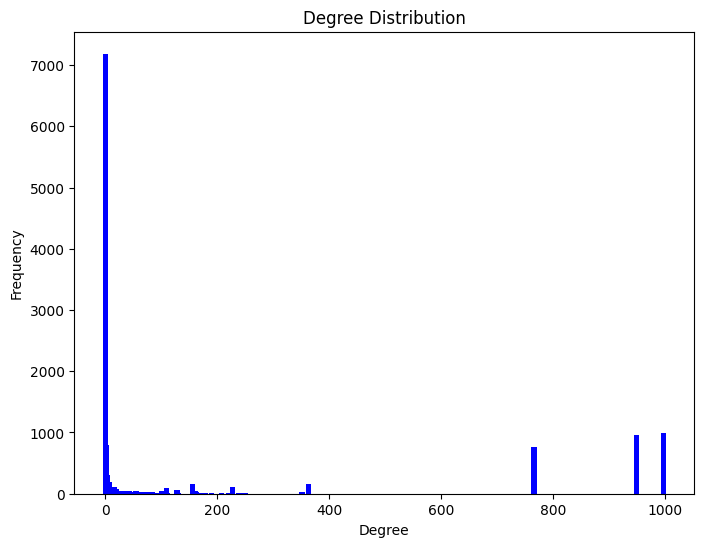

In [19]:
# Plot della degree distribution

# Calcolare i gradi dei nodi
degrees = [degree for node, degree in G.degree()]

# Calcolare la distribuzione dei gradi
degree_count = Counter(degrees)
deg, cnt = zip(*degree_count.items())

# Fare il plot della distribuzione dei gradi
plt.figure(figsize=(8, 6))
plt.bar(deg, cnt, width=10, color='b')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.show()

Osserviamo la presenza di una power law, ma probabilmente ci sono 3 componenti giganti connesse! Provo a estrarre utenti che fanno parte di quelle componenti e vedo i loro hashtags per confermare la presenza di componenti giganti.

In [58]:
print(degree_count)

Counter({0: 7186, 998: 999, 950: 951, 1: 796, 767: 768, 2: 484, 3: 309, 4: 234, 6: 190, 5: 188, 363: 161, 156: 157, 15: 114, 227: 108, 7: 103, 109: 91, 11: 86, 16: 81, 8: 80, 9: 77, 20: 75, 12: 74, 10: 70, 14: 59, 128: 53, 18: 52, 161: 51, 19: 47, 42: 46, 13: 46, 55: 43, 100: 42, 27: 42, 37: 41, 21: 41, 25: 39, 41: 39, 22: 38, 106: 37, 34: 36, 72: 36, 44: 35, 39: 35, 58: 34, 48: 34, 17: 34, 33: 33, 23: 32, 84: 31, 108: 31, 29: 30, 79: 30, 31: 28, 30: 28, 26: 26, 38: 26, 47: 25, 352: 25, 43: 24, 32: 24, 54: 23, 62: 22, 28: 21, 162: 21, 24: 21, 52: 20, 190: 19, 67: 17, 40: 14, 36: 14, 46: 14, 51: 12, 178: 11, 73: 10, 35: 10, 49: 10, 50: 10, 45: 9, 250: 9, 111: 9, 110: 8, 167: 8, 130: 8, 56: 8, 75: 8, 221: 7, 88: 6, 208: 6, 164: 6, 163: 6, 85: 6, 171: 5, 239: 5, 59: 5, 103: 5, 76: 5, 69: 5, 173: 5, 175: 4, 165: 4, 96: 4, 57: 4, 166: 3, 168: 3, 60: 3, 112: 3, 91: 3, 185: 3, 140: 3, 169: 3, 63: 3, 113: 3, 172: 3, 131: 2, 134: 2, 177: 2, 126: 2, 182: 2, 65: 2, 74: 2, 137: 2, 257: 2, 141: 2, 

In [68]:
#Prendiamo gli utenti che hanno degree 998.

desired_degree = 767 #950, #767

# Filtrare i nodi che hanno il grado specificato
nodes_with_desired_degree = [node for node, degree in degree_dict.items() if degree == desired_degree]

df_giant = df_final[df_final["user_screen_name"].isin(nodes_with_desired_degree)]
# Stampare i nodi con il grado desiderato
print(f"Nodi con grado {df_giant}:")
print(df_giant)

Nodi con grado       user_screen_name     hashtags
36882    StacyPatriot1  {#joebiden}
28199        NARedding  {#joebiden}
3559        AthemNejar  {#joebiden}
59175       kapaul_off  {#joebiden}
49560  cordiallyleslie  {#joebiden}
...                ...          ...
45613      ashley_6409  {#joebiden}
49808           croyus  {#joebiden}
50533     dawndevineny  {#joebiden}
1289          AV8TOR08  {#joebiden}
42784      XbandzSales  {#joebiden}

[768 rows x 2 columns]:
      user_screen_name     hashtags
36882    StacyPatriot1  {#joebiden}
28199        NARedding  {#joebiden}
3559        AthemNejar  {#joebiden}
59175       kapaul_off  {#joebiden}
49560  cordiallyleslie  {#joebiden}
...                ...          ...
45613      ashley_6409  {#joebiden}
49808           croyus  {#joebiden}
50533     dawndevineny  {#joebiden}
1289          AV8TOR08  {#joebiden}
42784      XbandzSales  {#joebiden}

[768 rows x 2 columns]


Come sospettato, le componenti connesse sono legate a 

In [41]:
"""
degree_dict = dict(G.degree())

# Ordinare i nodi per grado in ordine decrescente
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

num_top_nodes = 10

# Stampare i nodi con il grado più alto
print(f"I {num_top_nodes} nodi con il grado più alto sono:")
for node, degree in sorted_degree[:num_top_nodes]:
    print(f"Nodo: {node}, Grado: {degree}")
"""

I 10 nodi con il grado più alto sono:
Nodo: bhfmd, Grado: 998
Nodo: Kunal_Singh__, Grado: 998
Nodo: getsomesports, Grado: 998
Nodo: Mary65264888, Grado: 998
Nodo: mfz94jag, Grado: 998
Nodo: arnav_ganguly, Grado: 998
Nodo: SethAndrewsTTA, Grado: 998
Nodo: LouGarza86, Grado: 998
Nodo: Jlh1158Lee, Grado: 998
Nodo: GPEG62, Grado: 998


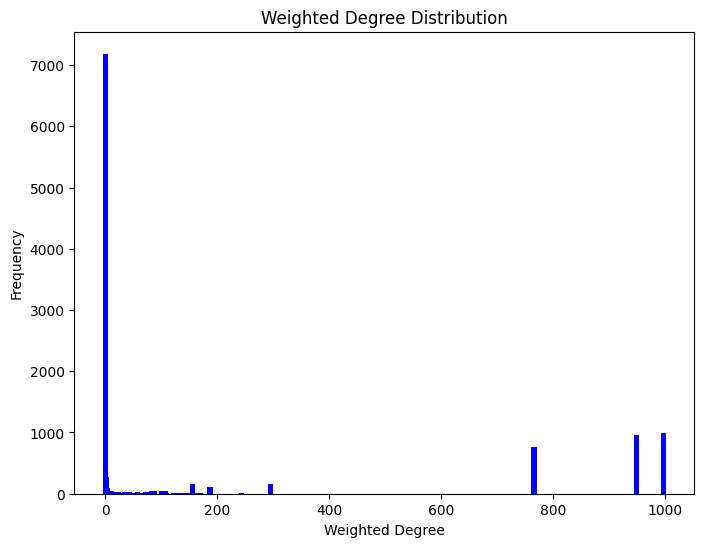

In [57]:
# Plot della weighted degree

# Calcolare il weighted degree dei nodi
weighted_degrees = dict(G.degree(weight='weight'))

# Calcolare la distribuzione del weighted degree
weighted_degree_count = Counter(weighted_degrees.values())
deg, cnt = zip(*weighted_degree_count.items())

# Fare il plot della distribuzione del weighted degree
plt.figure(figsize=(8, 6))
plt.bar(deg, cnt, width=10, color='b')

plt.title("Weighted Degree Distribution")
plt.xlabel("Weighted Degree")
plt.ylabel("Frequency")

plt.show()

Effettuo campionamento dei nodi tenendo conto della degree distribution dei nodi

In [ ]:
# Definire la funzione di campionamento basato sui gradi
def degree_based_sampling(graph, sample_size):
    # Calcolare i gradi dei nodi
    degrees = dict(graph.degree())
    nodes, degree_values = zip(*degrees.items())
    
    # Convertire i gradi in probabilità (più alto il grado, maggiore la probabilità di essere selezionato)
    total_degree = sum(degree_values)
    probabilities = [degree / total_degree for degree in degree_values]
    
    # Campionare i nodi in base alle probabilità
    sampled_nodes = np.random.choice(nodes, size=sample_size, replace=False, p=probabilities)
    
    # Restituire il sottografo campionato
    return graph.subgraph(sampled_nodes)

# Campionare il 20% dei nodi basato sui gradi
sample_size = int(len(G.nodes) * 0.2)
G_sampled = degree_based_sampling(G, sample_size)

# Calcolare la distribuzione dei gradi nel grafo campionato
sampled_degrees = [degree for node, degree in G_sampled.degree()]
sampled_degree_count = Counter(sampled_degrees)
sampled_deg, sampled_cnt = zip(*sampled_degree_count.items())

# Fare il plot della distribuzione dei gradi nel grafo campionato
plt.figure(figsize=(8, 6))
plt.bar(sampled_deg, sampled_cnt, width=0.80, color='b')

plt.title("Degree Distribution in Sampled Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

# Fare il plot della distribuzione dei gradi nel grafo originale per confronto
original_degrees = [degree for node, degree in G.degree()]
original_degree_count = Counter(original_degrees)
orig_deg, orig_cnt = zip(*original_degree_count.items())

plt.figure(figsize=(8, 6))
plt.bar(orig_deg, orig_cnt, width=0.80, color='r')

plt.title("Degree Distribution in Original Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

Analisi con le misure di centralità

In [21]:
# Degree Centrality
"""
degree_centrality = nx.degree_centrality(G)
degree_df = pd.DataFrame(list(degree_centrality.items()), columns=['user_screen_name', 'degree_centrality'])
degree_df = degree_df.sort_values(by='degree_centrality', ascending=False)
print(degree_df.head())
"""

degree_centrality = nx.degree_centrality(G)

# Ordiniamo i nodi in base ai valori di degree centrality in ordine decrescente
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di degree centrality
for node, centrality in sorted_degree[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Degree Centrality: {centrality:.6f}')

Nodo: bhfmd, Degree Centrality: 0.065421
Nodo: Kunal_Singh__, Degree Centrality: 0.065421
Nodo: getsomesports, Degree Centrality: 0.065421
Nodo: Mary65264888, Degree Centrality: 0.065421
Nodo: mfz94jag, Degree Centrality: 0.065421
Nodo: arnav_ganguly, Degree Centrality: 0.065421
Nodo: SethAndrewsTTA, Degree Centrality: 0.065421
Nodo: LouGarza86, Degree Centrality: 0.065421
Nodo: Jlh1158Lee, Degree Centrality: 0.065421
Nodo: GPEG62, Degree Centrality: 0.065421


In [ ]:
#Closeness 
"""
closeness_centrality = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['user_screen_name', 'closeness_centrality'])
closeness_df = closeness_df.sort_values(by='closeness_centrality', ascending=False)
print(closeness_df.head())
"""

closeness_centrality = nx.closeness_centrality(G)

# Ordiniamo i nodi in base ai valori di degree centrality in ordine decrescente
sorted_degree = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Stampiamo i nodi con i valori più alti di degree centrality
for node, centrality in sorted_degree[:10]: #stampo solo i migliori 10
    print(f'Nodo: {node}, Closeness Centrality: {centrality:.6f}')

### Community detection

### Influence maximization

# Costruisco la rete con similarità usando language model (llama3)

In [16]:
print(df_country["user_screen_name"].value_counts())
df_country_e_follower= df_country[df_country["user_followers_count"]<1000] 
print(f"Total tweets: {len(df_country_e_follower)}")
print(df_country_e_follower["user_screen_name"].value_counts())

#Concatenazione dei tweet per l'utente
grouped_df = df_country_e_follower.groupby('user_screen_name')['tweet'].apply(lambda tweets: ' '.join(tweets)).reset_index()
print(f"Total tweets after concate: {len(grouped_df)}")
print(len(grouped_df))
print(grouped_df["user_screen_name"].value_counts())

user_screen_name
steveziegenbus2    1259
JournalistJG       1059
mcleod              980
lookforsun          856
Starbright489       785
                   ... 
TxHellraiser76        1
tee_omm               1
LCarpen97702802       1
kylejust1ce           1
joebessemer           1
Name: count, Length: 76279, dtype: int64
Total tweets: 171749
user_screen_name
Starbright489    785
POTUSNetwork     709
THCPetDoctor     598
MaryC3           495
mrjustsaying     459
                ... 
Glendale314        1
susansbarash       1
ZenActivist        1
KellyHousman       1
alyseb1980         1
Name: count, Length: 56563, dtype: int64
Total tweets after concate: 56563
56563
user_screen_name
zzz_ooo_eee      1
000HMY           1
001Newway        1
007442008OB      1
007mdb           1
                ..
0m3gatron        1
0neofthe300      1
0nlyInFlorida    1
0paug            1
0rangepop        1
Name: count, Length: 56563, dtype: int64


In [ ]:
grouped_df.head()

In [ ]:
import requests
import json
import os
import time
from tqdm import tqdm

In [ ]:
#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh

In [ ]:
#un thread demone avvia il server locale di ollama
import subprocess
import threading
t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
t.start()

In [ ]:
#un altro thread demone avvia llama3
!ollama pull llama3
t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", "llama3"]),daemon=True)
t2.start()

In [ ]:
prompt = "You are a text-similarity evaluator. Your role is to analyze all the couple of tweets of users and calculate the semantic similarity between them. You must assign to each couple a decimal score from 0 (if the tweets are not similar) to 1 (if the tweets are similar). You have to give only the number score, not anymore. Let's think step by step, and taking the just amount of time you need to evaluate at the best of your capabilities."

In [ ]:
def ask_to_llama(tweet1,tweet2,prompt):   
    
    full_prompt = prompt + "Tweet 1: " + tweet1 + ". Tweet 2:" + tweet2
    
    response = requests.post('http://localhost:11434/api/generate', 
                             data=json.dumps({'model': 'llama3', 'prompt': full_prompt, 'stream': False}), 
                             headers={'Content-Type': 'application/json'})
    
    return response.json()['response']

In [ ]:
#Prova
"""
resp = ask_to_llama("nicola is stupid, and he is really bold", "smart person and with a lot of hair", prompt)
print(resp)

filename = '/kaggle/working/similarities.json'

with open(filename, 'w') as file:
    json.dump(resp, file)
"""

In [ ]:
import json

# Specifica il nome del file JSON
filename = '/kaggle/working/similarities.json'
records = []

for (user1, tweet1), (user2, tweet2) in combinations(grouped_df.itertuples(index=False), 2):
    resp = ask_to_llama(tweet1,tweet2,prompt)
    record = {
        "user1": user1,
        "user2": user2,
        "similarity": resp
    }
    records.append(record)
    
# Scrivi i dati nel file JSON
with open(filename, 'w') as file:
    json.dump(records, file)

In [ ]:
# Funzione per caricare il contenuto di un file JSON
def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Specifica il nome del file JSON
filename = '/kaggle/working/similarities.json'

# Carica i dati dal file JSON
data = load_json(filename)

In [ ]:
# Creare un grafo vuoto
G = nx.Graph()

Threshold = 0 #threshold similarità

# Itera su ogni record nel file JSON
for item in data:
    dictionary = dict(item.items())
    if not G.has_node(dictionary["user1"]): #se utente non presente, lo aggiungo alla rete
        G.add_node(dictionary["user1"])
    if not G.has_node(dictionary["user2"]): #se utente non presente, lo aggiungo alla rete
        G.add_node(dictionary["user2"])
    if float(dictionary["similarity"])>Threshold:
        G.add_edge(dictionary["user1"], dictionary["user2"], weight=float(dictionary["similarity"]))
    

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

In [ ]:
# Disegnare il grafo
pos = nx.spring_layout(G)  # Posizionamento dei nodi
weights = nx.get_edge_attributes(G, 'weight').values()

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=5, font_size=5, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}, font_color='red')
nx.draw_networkx_edges(G, pos, width=list(weights))

plt.show()